In [1]:
import matplotlib.pyplot as plt 
import plots 
plots.mpltoolkit.load_mpl_presets() 
import numpy as np 
import vice 
import sys 
sys.path.append("../") 
import src 

In [2]:
vice.yields.ccsne.settings['o'] = 0.015 
vice.yields.ccsne.settings['fe'] = 0.0012 
vice.yields.ccsne.settings['n'] = 4.15e-4 
vice.yields.sneia.settings['o'] = 0.0 
vice.yields.sneia.settings['fe'] = 0.0017 
vice.yields.sneia.settings['n'] = 0.0 

In [3]:
def setup_axis(): 
    r"""
    Setup a single subplot to plot the model-predicted [N/O]-[O/H] 
    relation from one-zone models on. 
    """ 
    fig = plt.figure(figsize = (14, 7), facecolor = "white") 
    ax1 = fig.add_subplot(121) 
    ax2 = fig.add_subplot(122, sharey = ax1)  
    for ax in [ax1, ax2]: ax.set_xlabel("[O/H]") 
    plt.setp(ax2.get_yticklabels(), visible = False) 
    ax1.set_ylabel("[N/O]") 
    return [ax1, ax2] 

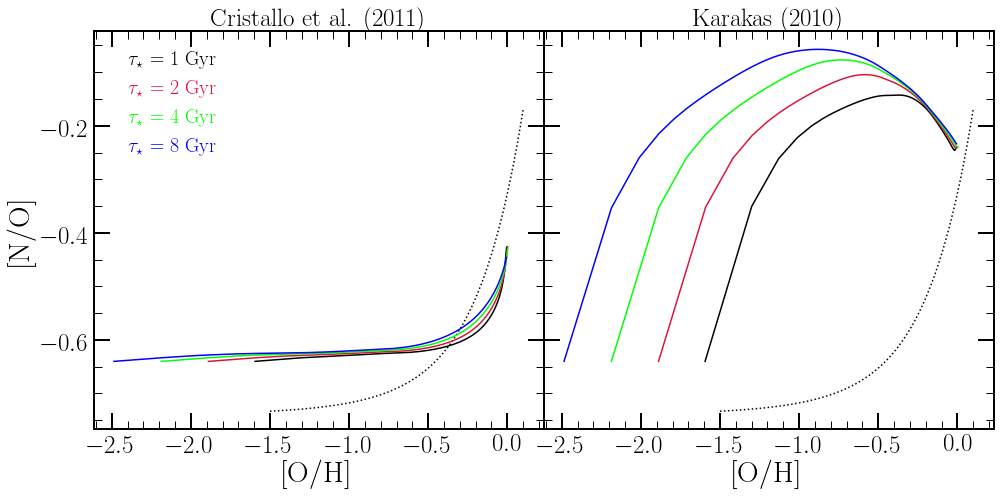

In [4]:
def sfr(time): 
    r""" 
    Star formation rate as a function of time. Here using constant for 
    the sake of simplicity. 
    """ 
    return 1. 

tau_star = [1, 2, 4, 8] 
colors = ["black", "crimson", "lime", "blue"] 

axes = setup_axis() 
agb_models = ["cristallo11", "karakas10"] 
axes[0].set_title("Cristallo et al. (2011)", fontsize = 25) 
axes[1].set_title("Karakas (2010)", fontsize = 25) 
no_oh_relation = src.no_oh_relation.Henry2000() 
for y in range(len(agb_models)): 
    vice.yields.agb.settings['n'] = agb_models[y] 
    xvals = [-1.5 + 0.01 * i for i in range(161)] 
    axes[y].plot(xvals, [no_oh_relation(i) for i in xvals], linestyle = ':', 
        c = plots.mpltoolkit.named_colors()["black"]) 
    for i in range(len(tau_star)): 
        sz = vice.singlezone(name = "taustar_%g" % (tau_star[i]), 
            tau_star = tau_star[i], mode = "sfr", func = sfr, 
            elements = ["fe", "o", "n"], eta = 2.0)  
        out = sz.run(np.linspace(0, 12.2, 1221), overwrite = True, capture = True) 
        kwargs = {"c": plots.mpltoolkit.named_colors()[colors[i]]} 
        if not y: kwargs["label"] = r"$\tau_\star$ = %g Gyr" % (tau_star[i]) 
        axes[y].plot(out.history["[O/H]"], out.history["[N/O]"], **kwargs) 
        
leg = axes[0].legend(loc = plots.mpltoolkit.mpl_loc("upper left"), fontsize = 20, ncol = 1, 
    frameon = False, handlelength = 0) 
for i in range(len(tau_star)): 
    leg.legendHandles[i].set_visible(False) 
    leg.get_texts()[i].set_color(colors[i]) 
plt.tight_layout() 
plt.subplots_adjust(wspace = 0) 
for ext in ["pdf", "png"]: plt.savefig("onezone_cristallo_karakas.%s" % (ext)) 

/Users/astrobeard/anaconda3/lib/python3.7/site-packages/vice/core/singlezone/singlezone.py:1761: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  overwrite = overwrite)
/Users/astrobeard/anaconda3/lib/python3.7/site-packages/vice/core/pickles.py:307: UserWarning: Could not pickle function. The following attribute will not be saved with this output: n
  this output: %s""" % (self.name), UserWarning)
/Users/astrobeard/anaconda3/lib/python3.7/site-packages/vice/core/outputs/output.py:131: UserWarning: agb n yield not encoded with output. Assuming the current yield setting, which may not reflect the yield setting at the time the simulation was ran.
  self.__c_version = c_output(name)


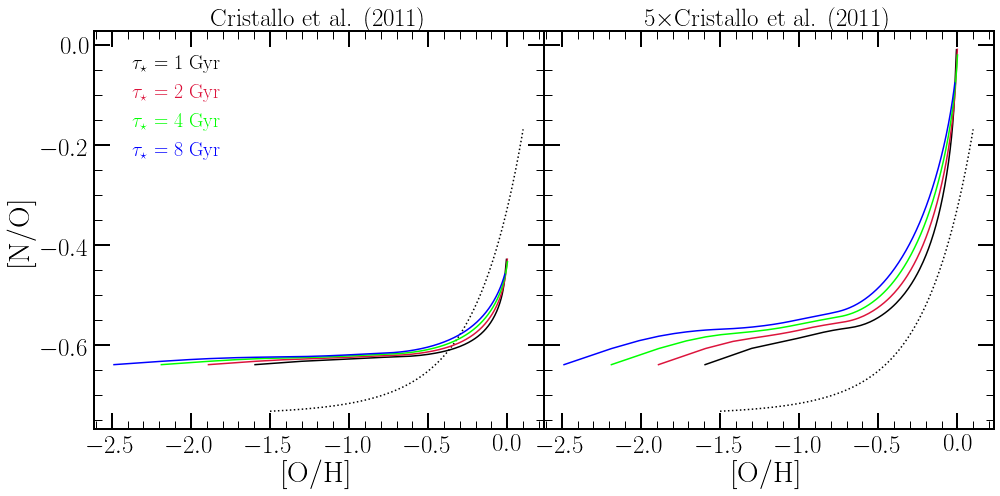

In [5]:
PREFACTOR = 5 
class amplified_agb(vice.yields.agb.interpolator): 
    def __call__(self, mass, metallicity): 
        return PREFACTOR * super().__call__(mass, metallicity) 

axes = setup_axis() 
axes[0].set_title("Cristallo et al. (2011)", fontsize = 25) 
axes[1].set_title(r"%g$\times$Cristallo et al. (2011)" % (PREFACTOR), fontsize = 25) 
for y in range(2): 
    axes[y].plot(xvals, [no_oh_relation(i) for i in xvals], linestyle = ':', 
        c = plots.mpltoolkit.named_colors()["black"]) 
    for i in range(len(tau_star)): 
        kwargs = {"c": plots.mpltoolkit.named_colors()[colors[i]]} 
        if y: 
            vice.yields.agb.settings['n'] = amplified_agb('n') 
            sz = vice.singlezone(name = "taustar_%g_ampagb" % (tau_star[i]), 
                func = sfr, mode = "sfr", tau_star = tau_star[i], 
                elements = ["fe", "o", "n"], eta = 2.0) 
            out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True) 
            axes[y].plot(out.history["[o/h]"], out.history["[n/o]"], **kwargs) 
        else: 
            vice.yields.agb.settings['n'] = "cristallo11" 
#             out = vice.output("taustar_%g" % (tau_star[i])) 
            sz = vice.singlezone(name = "taustar_%g_ampagb" % (tau_star[i]), 
                func = sfr, mode = "sfr", tau_star = tau_star[i], 
                elements = ["fe", "o", "n"], eta = 2.0) 
            out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True) 
            kwargs["label"] = r"$\tau_\star$ = %g Gyr" % (tau_star[i]) 
            axes[y].plot(out.history["[o/h]"], out.history["[n/o]"], **kwargs) 
leg = axes[0].legend(loc = plots.mpltoolkit.mpl_loc("upper left"), ncol = 1, frameon = False, 
    bbox_to_anchor = (0.01, 0.99), handlelength = 0, fontsize = 20) 
for i in range(len(tau_star)): 
    leg.get_texts()[i].set_color(colors[i]) 
    leg.legendHandles[i].set_visible(False) 
plt.tight_layout() 
plt.subplots_adjust(wspace = 0) 
for ext in ["pdf", "png"]: plt.savefig("onezone_cristallo.%s" % (ext)) 